In [1]:
import torch
from torch import nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import re
import pandas as pd

## Load Dataset

In [2]:
df = pd.read_csv('esol.csv')
df = df[['measured log solubility in mols per litre','smiles']]

In [3]:
train_df, validate_df, test_df = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

## Constructing Vocabulary from the dataset

In [4]:
elements = {'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S','H','Si'}
vocab = set()
for indx,val in enumerate(list(df['smiles'].values)):
    temp_smile = re.sub(' ','',val)   ##remove spaces from the smile string
    for element in elements:
        search_obj = re.search(element,temp_smile)
        if search_obj:
            temp_smile = re.sub(element,'',temp_smile)
            vocab.add(element)
        search_obj = re.search(element.lower(),temp_smile)
        if search_obj:
            temp_smile = re.sub(element.lower(),'',temp_smile)
            vocab.add(element.lower())
    
    for i in temp_smile:
        vocab.add(i)
## convert vocab from set to list for indexing
vocab = list(vocab)

## Convert SMILES to vector representation

In [5]:
def smiles2vec(smile):
    indx = 0
    vec = []
    smile = smile.strip()
    while indx < len(smile):
        if (indx is not len(smile) - 1) and (smile[indx] + smile[indx+1]) in vocab:
            vec.append(vocab.index(smile[indx] + smile[indx+1]))
            indx += 2
            output of shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features h_t from the last layer of the GRU, for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the input, the output will also be a packed sequence. For the unpacked case, the directions can be separated using output.view(seq_len, batch, num_directions, hidden_size), with forward and backward being direction 0 and 1 respectively.
        elif (smile[indx]) in vocab:
            vec.append(vocab.index(smile[indx]))
            indx += 1
            
    return vec

# Hyper Parameters for model

In [6]:
INPUT_SIZE = 1      # rnn input size
HIDDEN_SIZE = 120      # rnn hidden size
LR = 1e-2         # learning rate
BATCH_SIZE = 32

## Model

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,     # rnn hidden unit
            num_layers=1,                # number of rnn layer
            batch_first = True,
        )
        self.out = nn.Linear(HIDDEN_SIZE, 60)
        self.final = nn.Linear(60, 1)

    def forward(self, x, time_step):
        h_state = torch.zeros(1,1,HIDDEN_SIZE).float()
        r_out, h_state = self.rnn(x.float(), h_state)
        r_out = torch.mean(r_out,dim=1)
        r_out = self.out(r_out)
        r_out = F.relu(r_out)
        prediction = self.final(r_out)
        return prediction

## Initializing model, optimizer and LR scheduler

In [8]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=5)

## Training 

In [9]:
def train(epoch,train_set):
    model.train()
    sample_index = 0
    epoch_train_loss=[]
    random_indexes=np.random.permutation(len(train_set))
    MAXITER = len(train_set)/BATCH_SIZE
    for batch_no in range(0,round(MAXITER)):
        optimizer.zero_grad()
        train_loss = torch.zeros(1, 1)
        
        for iter_no in range(0, BATCH_SIZE):
            sample_index = sample_index%len(train_set)
            index=random_indexes[sample_index]
            data = train_set[index]
    
            smile = data[1]
            smile_vec = smiles2vec(smile)
            smile_vec = torch.FloatTensor(smile_vec)
            smile_vec = smile_vec.unsqueeze(0)
            smile_vec = smile_vec.unsqueeze(2)
            y_hat = model(smile_vec,smile_vec.shape[1])
            
            y = torch.FloatTensor([data[0]])
            error = ((y_hat - y)**2 / BATCH_SIZE)
            train_loss = train_loss + error
            
            sample_index += 1

        epoch_train_loss.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
    
    return np.mean(epoch_train_loss)

## Validation 

In [10]:
def validation():
    model.eval()
    val_loss = torch.zeros(1, 1)
    for index,data in enumerate(validate_df.values):
        smile = data[1]
        smile_vec = smiles2vec(smile)
        smile_vec = torch.FloatTensor(smile_vec)
        smile_vec = smile_vec.unsqueeze(0)
        smile_vec = smile_vec.unsqueeze(2)
        y_hat = model(smile_vec,smile_vec.shape[1])

        y = torch.FloatTensor([data[0]])
        error = (y_hat - y)**2
        val_loss = val_loss + error

    return val_loss.item()/len(validate_df)

## Test

In [16]:
def test():
    model.eval()
    test_loss = torch.zeros(1, 1)
    for index,data in enumerate(test_df.values):
        smile = data[1]
        smile_vec = smiles2vec(smile)
        smile_vec = torch.FloatTensor(smile_vec)
        smile_vec = smile_vec.unsqueeze(0)
        smile_vec = smile_vec.unsqueeze(2)
        y_hat = model(smile_vec,smile_vec.shape[1])

        y = torch.FloatTensor([data[0]])
        error = (y_hat - y)**2
        test_loss = test_loss + error

    return test_loss.item()/len(test_df)

## Training loop

In [12]:
train_loss_arr = []
validation_loss_arr = []
for epoch in range(100):
    train_loss = train(epoch,train_df.values)
    val_loss = validation()
    train_loss_arr.append(train_loss)
    validation_loss_arr.append(val_loss)
    print("epoch_no: ",epoch ,"training loss: ",train_loss,"validation loss: ",val_loss)
    scheduler.step(val_loss)

epoch_no:  0 training loss:  5.084271422454289 validation loss:  5.0465714446211285
epoch_no:  1 training loss:  3.8979566182409013 validation loss:  4.596451210764657
epoch_no:  2 training loss:  3.3083095805985585 validation loss:  3.829869903294386
epoch_no:  3 training loss:  3.194009014538356 validation loss:  4.551993851113108
epoch_no:  4 training loss:  3.930888754980905 validation loss:  4.181043236656526
epoch_no:  5 training loss:  3.2994715571403503 validation loss:  3.908340859202157
epoch_no:  6 training loss:  3.1603835821151733 validation loss:  3.7326535925400997
epoch_no:  7 training loss:  3.02769005724362 validation loss:  4.867313891385509
epoch_no:  8 training loss:  3.194287679025105 validation loss:  4.490997044386062
epoch_no:  9 training loss:  3.000466376543045 validation loss:  3.7352926878802544
epoch_no:  10 training loss:  2.7291683426925113 validation loss:  3.3736971964878317
epoch_no:  11 training loss:  2.681775403874261 validation loss:  3.1110504960

epoch_no:  94 training loss:  0.9926733012710299 validation loss:  1.6055445038111864
epoch_no:  95 training loss:  0.987243286200932 validation loss:  1.6055166869036919
epoch_no:  96 training loss:  0.988683181149619 validation loss:  1.6063147350750138
epoch_no:  97 training loss:  0.9899981319904327 validation loss:  1.607507756326051
epoch_no:  98 training loss:  0.9863832103354591 validation loss:  1.6070976594908049
epoch_no:  99 training loss:  0.9906572891133172 validation loss:  1.6069677572334762
Epoch    99: reducing learning rate of group 0 to 1.0000e-06.


In [17]:
print("Test loss: ",test())

Test loss:  1.098492782727807


## Training and validaiton loss v/s epoch

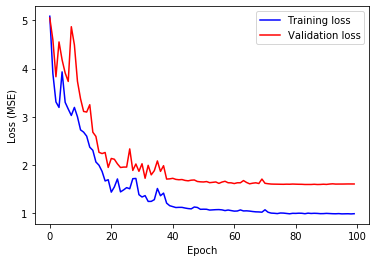

In [13]:
plt.plot(train_loss_arr,'b',label='Training loss')
plt.plot(validation_loss_arr,'r',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.plot()
plt.show()